In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!unzip -uq '/content/gdrive/My Drive/CheXpert-v1.0-small.zip'

In [24]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import auc, roc_curve, f1_score, accuracy_score
%matplotlib inline
from matplotlib import pyplot as plt
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.applications.xception import preprocess_input as pi_xception
from keras.applications.inception_resnet_v2 import preprocess_input as pi_irnv2

In [25]:
MODEL_NAMES = ['xception', 'irnv2', 'dn121', 'dn169', 'dn201']

In [26]:
PATHS_ARCH = {
    'xception' : '/content/gdrive/My Drive/Model-Architectures/architecture_xception.json',
    'irnv2'    : '/content/gdrive/My Drive/Model-Architectures/architecture_irnv2.json',
    'dn121'    : '/content/gdrive/My Drive/Model-Architectures/architecture_dn121.json',
    'dn169'    : '/content/gdrive/My Drive/Model-Architectures/architecture_dn169.json',
    'dn201'    : '/content/gdrive/My Drive/Model-Architectures/architecture_dn201.json'
}

PATHS_WEIGHTS = {
    'xception' : '/content/gdrive/My Drive/Model-Weights/xception.h5',
    'irnv2'    : '/content/gdrive/My Drive/Model-Weights/irnv2.h5',
    'dn121'    : '/content/gdrive/My Drive/Model-Weights/dn121.h5',
    'dn169'    : '/content/gdrive/My Drive/Model-Weights/dn169.h5',
    'dn201'    : '/content/gdrive/My Drive/Model-Weights/dn201.h5'
}

In [27]:
PREPROCESS_INPUTS = {
    'xception' : pi_xception,
    'irnv2'    : pi_irnv2,
    'dn121'    : None,
    'dn169'    : None,
    'dn201'    : None
}

In [28]:
MODELS = {
    'xception' : None,
    'irnv2'    : None,
    'dn121'    : None,
    'dn169'    : None,
    'dn201'    : None
}

PREDICTIONS = {
    'xception' : None,
    'irnv2'    : None,
    'dn121'    : None,
    'dn169'    : None,
    'dn201'    : None
} 

Y_HAT = {
    'xception' : None,
    'irnv2'    : None,
    'dn121'    : None,
    'dn169'    : None,
    'dn201'    : None
}

THRESHOLDS = {
    'xception' : None,
    'irnv2'    : None,
    'dn121'    : None,
    'dn169'    : None,
    'dn201'    : None
}

In [29]:
 def build_models():
  for model_name in MODEL_NAMES: 
      json_file = open(PATHS_ARCH[model_name], 'r')
      model_architecture = json_file.read()
      json_file.close()
      model = model_from_json(model_architecture)
      model.load_weights(PATHS_WEIGHTS[model_name])
      MODELS[model_name] = model

In [30]:
def get_probabilities(raw_img):
  predictions = {
      'xception' : None,
      'irnv2'    : None
  }
  for model_name in MODEL_NAMES: 
    img = preprocess(raw_img, preproc_func = PREPROCESS_INPUTS[model_name])
    model = MODELS[model_name]
    predictions[model_name] = model.predict(img)[0]
  return predictions

In [31]:
def preprocess(raw_img, preproc_func = None):
  img = cv2.resize(raw_img, (224, 224))
  if preproc_func != None:
    img = preproc_func(img)
  else: 
    img = img/255.
  img = img.reshape(1, 224, 224, 3)
  return img

In [32]:
CLASSES = [ 
  'Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Pleural Effusion'
]
N_CLASSES = len(CLASSES)
df_val = pd.read_csv('CheXpert-v1.0-small/valid.csv')
df_val = df_val[[
  'Path', 
  'Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Pleural Effusion'
]]
y_true = df_val[CLASSES].to_numpy()

In [33]:
build_models()

In [34]:
preds = []
for filename in tqdm(df_val.Path):
  raw_img = cv2.imread(filename)
  preds.append(get_probabilities(raw_img))

for model_name in MODEL_NAMES:
  PREDICTIONS[model_name] = np.array([p[model_name] for p in preds])

100%|██████████| 234/234 [06:04<00:00,  1.56s/it]


In [35]:
def plot_roc(prediction):
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')

  for i in range(N_CLASSES):
    fpr, tpr, thresholds = roc_curve(y_true[:, i], prediction[:, i])
    individual_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label= (CLASSES[i] + '(area = {0:.3g})'.format(individual_auc)))

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

In [36]:
def get_opt_thresh(prediction):
  J_stats = [None]*N_CLASSES
  opt_thresholds = [None]*N_CLASSES
  for i in range(N_CLASSES):
    fpr, tpr, thresholds = roc_curve(y_true[:, i], prediction[:, i])
    J_stats[i] = tpr - fpr # sensitivity - (1 - specificity)
    opt_thresholds[i] = thresholds[np.argmax(J_stats[i])]
  return opt_thresholds

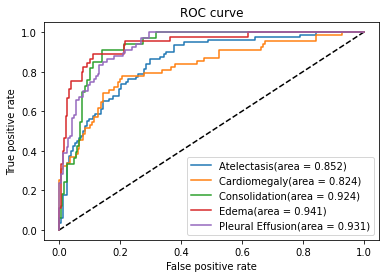

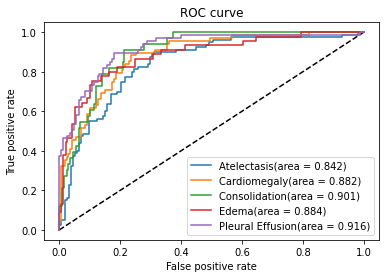

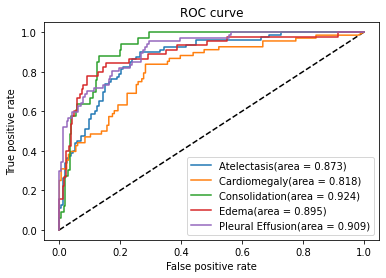

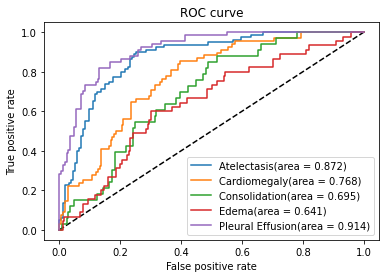

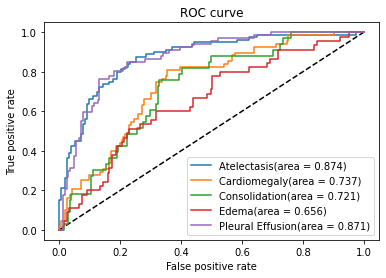

In [37]:
for model_name in MODEL_NAMES:
  plot_roc(PREDICTIONS[model_name])

In [38]:
for model_name in MODEL_NAMES:
  THRESHOLDS[model_name] = get_opt_thresh(PREDICTIONS[model_name])

In [39]:
def predict(preds, thresh):
  y_hat = np.zeros(preds.shape)
  for i in range(N_CLASSES):
    y_hat[:, i] = preds[:, i] >= thresh[i]
  return y_hat

In [40]:
for model_name in MODEL_NAMES:
  Y_HAT[model_name] = predict(PREDICTIONS[model_name], THRESHOLDS[model_name])

In [41]:
for model_name in MODEL_NAMES:
  print("{} : F1-Score : {}".format(model_name, f1_score(y_true, Y_HAT[model_name], average=None)))
  print("{} : Categorical Accuracy : {}".format(model_name, accuracy_score(y_true, Y_HAT[model_name])))

xception : F1-Score : [0.70769231 0.68387097 0.65934066 0.75471698 0.76821192]
xception : Categorical Accuracy : 0.4658119658119658
irnv2 : F1-Score : [0.72       0.71856287 0.56603774 0.68686869 0.76433121]
irnv2 : Categorical Accuracy : 0.44871794871794873
dn121 : F1-Score : [0.74611399 0.6627907  0.65909091 0.67857143 0.71111111]
dn121 : Categorical Accuracy : 0.41025641025641024
dn169 : F1-Score : [0.7539267  0.60416667 0.34939759 0.41860465 0.76388889]
dn169 : Categorical Accuracy : 0.2948717948717949
dn201 : F1-Score : [0.74074074 0.6043956  0.40322581 0.41441441 0.72857143]
dn201 : Categorical Accuracy : 0.3034188034188034


## Ensemble :

In [176]:
WEIGHTS = {
    'xception' : [0.20, 0.50, 1.00, 1.00, 1.00],
    'irnv2'    : [0.10, 1.00, 0.50, 0.00, 0.75],
    'dn121'    : [1.00, 1.00, 1.00, 0.10, 0.60],
    'dn169'    : [1.00, 0.00, 0.05, 0.00, 0.40],
    'dn201'    : [1.00, 0.00, 0.05, 0.00, 0.10]
}
factor=1.0/np.sum(np.array(list(WEIGHTS.values())), axis=0)
normalized_W = {k: v*factor for k, v in WEIGHTS.items() }

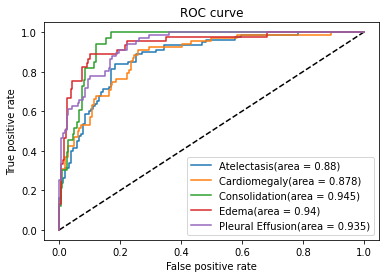


  Thresholds: [0.05426298921758479, 0.0088127850741148, 0.01122600500686811, 0.04146474762396379, 0.0347244671039414]
  F1-Score  : [0.76571429 0.71676301 0.66       0.76923077 0.75449102]
  Categorical Accuracy : 0.48717948717948717



In [177]:
"""Ensembling the models"""

sum = 0
for model_name in MODEL_NAMES:
  sum += PREDICTIONS[model_name] * normalized_W[model_name]
ensembled_predictions = sum/len(MODEL_NAMES)

plot_roc(ensembled_predictions)
thresh = get_opt_thresh(ensembled_predictions)
y_hat = predict(ensembled_predictions, thresh)
f1 = f1_score(y_true, y_hat, average=None)
catacc = accuracy_score(y_true, y_hat)

print("""
  Thresholds: {}
  F1-Score  : {}
  Categorical Accuracy : {}
""".format(thresh, f1, catacc))